# step-1
    # making a fork of the original repository
# step-2
    # creating branch understanding-[model-name] on the fork's local clone
    # create basic inference script which contains all the necessary basic model, and printing its parameters.
    # pushing this to the fork
# step-3
    # creating a new google-drive folder, and google colab notebook inside it
        # REASONS
            # This helps not installing all the requirements again and again.
            # Google Colab has preinstalled libraries, almost all which are necessary.
# step-4
    #

/usr/local/lib/python3.10/dist-packages/timm/models
/content/AudioMAE


In [1]:
# # permanently installing the libraries.
# from google.colab import drive
# import os, sys

# drive.flush_and_unmount()
# drive.mount('/content/drive/')
# nb_path = '/content/notebooks'
# os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
# sys.path.insert(0,nb_path)
# # !pip install --target=$nb_path timm -q
# # !pip install --target=$nb_path datasets -q

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive/


In [ ]:
!pip install timm
!pip install datasets
!pip install ipdb

In [5]:
%pdb on

Automatic pdb calling has been turned ON


In [2]:
# cloning the repo, and setting paths, unziping checkpoints.
from google.colab import drive
drive.flush_and_unmount()
%cd /content
%rm -r *
!git clone -b understanding_audiomae https://github.com/ps4vs/AudioMAE.git
drive.mount('/content/drive/')
CKPT = "/content/drive/MyDrive/AudioMAE/ckpt"
!unzip $CKPT".zip"
drive.flush_and_unmount()
%cd AudioMAE

Drive not mounted, so nothing to flush and unmount.
/content
Cloning into 'AudioMAE'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 137 (delta 37), reused 29 (delta 14), pack-reused 76
Receiving objects: 100% (137/137), 4.58 MiB | 6.23 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Mounted at /content/drive/
Archive:  /content/drive/MyDrive/AudioMAE/ckpt.zip
   creating: ckpt/
  inflating: ckpt/finetuned.pth      
  inflating: ckpt/pretrained.pth     
/content/AudioMAE


In [35]:
import torch
from torchvision import transforms
from datasets import load_dataset, Dataset, Audio
from torchaudio.compliance import kaldi

import os
import librosa
import random
import requests
import importlib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import models_mae

In [5]:
# !git reset --hard 6f5b6904933d659a5e82e83a052a65f3280ae25d
# !bash timm_patch.sh

HEAD is now at 6f5b690 updated inference.py


In [ ]:
# !python inference.py

In [52]:
MELBINS = 128
TARGET_LEN =1024
DATASET = load_dataset("agkphysics/audioset", split="train", streaming=True)

def checkpoint_filter_fn(state_dict, model):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    state_dict = state_dict.get('model', state_dict)
    state_dict = state_dict.get('state_dict', state_dict)
    if 'head.fc.weight' in state_dict:
        return state_dict
    out_dict = {}
    for k, v in state_dict.items():
        if 'tau' in k:
            # convert old tau based checkpoints -> logit_scale (inverse)
            v = torch.log(1 / v)
            k = k.replace('tau', 'logit_scale')
        k = k.replace('head.', 'head.fc.')
        out_dict[k] = v
    return out_dict

def prepare_model(ckpt_dir='../ckpt/pretrained.pth', arch='mae_vit_base_patch16'):
    ## LOAD MODEL
    model = getattr(models_mae, arch)(in_chans=1, audio_exp=True, img_size=(1024, 128), decoder_mode=1, decoder_depth=16)
    # this checkpoint dir is being loaded directly
    checkpoint = torch.load(ckpt_dir, map_location='cpu')
    checkpoint = checkpoint_filter_fn(checkpoint, model)

    ## EQUIQ WEIGHTS
    msg = model.load_state_dict(checkpoint, strict=False)
    print(msg)
    # when the model weights are available on some url.
    # state_dict = torch.hub.load_state_dict_from_url('url.pth')
    return model

def wav2fbank(example):
    waveform, sr = (example['flac']['array'], example['flac']['sampling_rate'])
    waveform = waveform - waveform.mean()
    waveform = torch.tensor(waveform, device='cpu')
    waveform = waveform.unsqueeze(dim=0)
    fbank = kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
                        window_type='hanning', num_mel_bins=MELBINS, dither=0.0, frame_shift=10)

    n_frames = fbank.shape[0]
    p = TARGET_LEN - n_frames

    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:TARGET_LEN, :]
    return fbank

def norm_fbank(fbank):
    norm_mean = -4.2677393
    norm_std = 4.5689974
    fbank = (fbank - norm_mean) / (norm_std * 2)
    return fbank

def display_images(data, minmin=None, maxmax=None):

    if minmin == None and maxmax == None:
        minmin = np.min([d[0].min() for d in data])
        maxmax = np.max([d[0].max() for d in data])
        minmin *= 10
        maxmax *= 1
        minmin=-10
        maxmax=10

    _, axes = plt.subplots(len(data), 1, figsize=(6, 6))
    for i, bank in enumerate(data):
        axes[i].imshow(
            20 * bank.T.numpy(),
            origin='lower',
            interpolation='nearest',
            vmax=maxmax, vmin=minmin,
            aspect='auto'
        )
        axes[i].axis('off')
    plt.show()

def get_fbanks(n_examples):
    dataset_head = DATASET.take(100)
    dataset_head.cast_column('flac', Audio(sampling_rate=16_000))
    total = [x for x in iter(dataset_head)]
    examples = random.choices(total, k=n_examples)
    fbanks = []
    for example in examples:
        fbank = wav2fbank(example)
        fbank = norm_fbank(fbank)
        fbanks.append(fbank)
    display_images(fbanks)

    return fbanks

def prepare_model_input(fbank):
    x = torch.tensor(fbank)
    x = x.unsqueeze(dim=0)
    x = x.unsqueeze(dim=0)
    return x


Resolving data files:   0%|          | 0/882 [00:00<?, ?it/s]

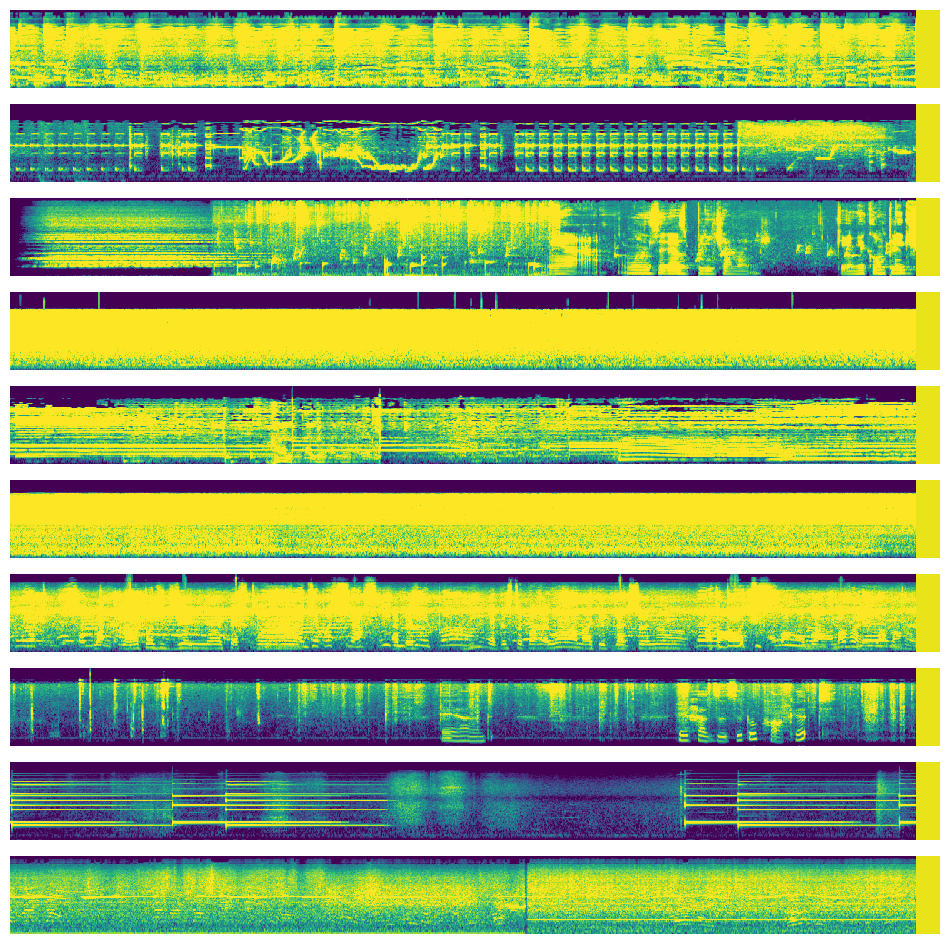

In [44]:
fbanks = get_fbanks(10)

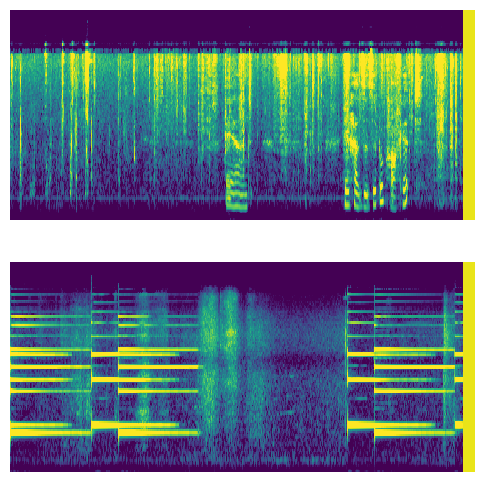

In [54]:
display_images([fbanks[-3], fbanks[-2]])

In [57]:
x = prepare_model_input(fbanks[-3])

<ipython-input-52-faded50a3942>:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(fbank)


In [55]:
importlib.reload(models_mae)
model = prepare_model()
print("MODEL and DATA LOADED")

<All keys matched successfully>
MODEL and DATA LOADED


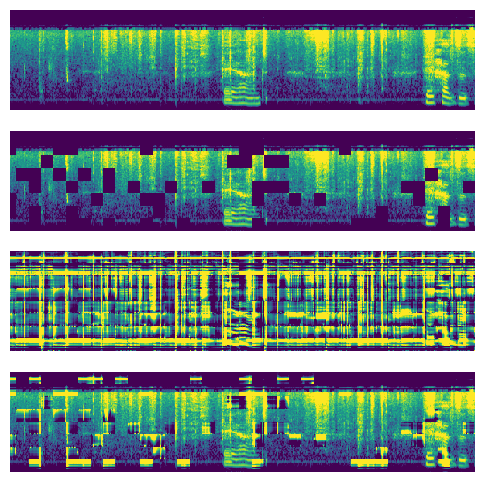

In [60]:
loss, y, mask, _ = model(x.float(), mask_ratio=0.2)
y = model.unpatchify(y)
y = torch.einsum('nchw->nhwc', y).detach().cpu()

mask = mask.detach()
mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *1)
mask = model.unpatchify(mask)
mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

x = torch.einsum('nchw->nhwc', x)
im_masked = x * (1 - mask)
im_paste = x * (1 - mask) + y * mask
im_masked2 = im_masked + (mask)*-10


minmin = np.min([x[0].min(), im_masked[0].min(), y[0].min(), im_paste[0].min()])
maxmax = np.max([x[0].max(), im_masked[0].max(), y[0].max(), im_paste[0].max()])
minmin *= 10
maxmax *= 1
minmin=-10
maxmax=10
start=200
end=800

original = x[0][start:end].squeeze()
masked = im_masked2[0][start:end].squeeze()
resulted = y[0][start:end].squeeze()
final = im_paste[0][start:end].squeeze()

display_images(
    data = [original, masked, resulted, final],
    minmin=minmin, maxmax=maxmax
)

x = torch.einsum('nhwc->nchw', x)